In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
import cv2
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
import warnings
import random

# Configuration
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('default')


In [2]:
# Dataset path (*You guys should change path according to where your plantvillage folder is located*)
dataset_path = "/Users/muhammadhassan/Documents/Personal Publications /Education /Heriot-Watt/4th Year UG /1st Sem/F21DL DMML/Group CW/Datasets /Plant Datasets/PlantVillage"

# Configuration parameters
TARGET_SIZE = (224, 224)  # Standard size 
TEST_SIZE = 0.3  # 30% for testing, 70% for training
RANDOM_STATE = 42  # For reproducibility

# Check if dataset path exists
if os.path.exists(dataset_path):
    print(f" Dataset path found: {dataset_path}")
    print(f" Folder contents: {os.listdir(dataset_path)[:5]}...")  # Show first 5 items
else:
    print(f"Dataset path not found: {dataset_path}")
    print(" check the path and update ")

 Dataset path found: /Users/muhammadhassan/Documents/Personal Publications /Education /Heriot-Watt/4th Year UG /1st Sem/F21DL DMML/Group CW/Datasets /Plant Datasets/PlantVillage
 Folder contents: ['Tomato_healthy', 'Potato___Early_blight', 'Tomato_Early_blight', '.DS_Store', 'Potato___Late_blight']...


In [3]:
print("\n")
print("DATASET STRUCTURE ANALYSIS")
print("\n")

# Get all class folders
class_names = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')]
class_names.sort()

print(f"Number of classes found: {len(class_names)}")
print(f"Classes found:")
for i, class_name in enumerate(class_names, 1):
    print(f"  {i:2d}. {class_name}")



DATASET STRUCTURE ANALYSIS


Number of classes found: 7
Classes found:
   1. Potato___Early_blight
   2. Potato___Late_blight
   3. Potato___healthy
   4. Tomato_Bacterial_spot
   5. Tomato_Early_blight
   6. Tomato_Late_blight
   7. Tomato_healthy


In [4]:
print("\n")
print("COUNTING IMAGES IN EACH CLASS")
print("\n")

class_counts = {}
total_images = 0

# Valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg')

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    
    # Get image files only
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(valid_extensions)]
    
    class_counts[class_name] = len(image_files)
    total_images += len(image_files)
    
    print(f"{class_name:40} : {len(image_files):5,} images")

print(f"\n{'TOTAL':40} : {total_images:5,} images")
print(f"Average per class: {total_images/len(class_names):,.1f} images")



COUNTING IMAGES IN EACH CLASS


Potato___Early_blight                    : 1,000 images
Potato___Late_blight                     : 1,000 images
Potato___healthy                         : 1,331 images
Tomato_Bacterial_spot                    : 2,127 images
Tomato_Early_blight                      : 1,000 images
Tomato_Late_blight                       : 1,909 images
Tomato_healthy                           : 1,591 images

TOTAL                                    : 9,958 images
Average per class: 1,422.6 images




Visualize Class Distribution (partial code from GenAI)




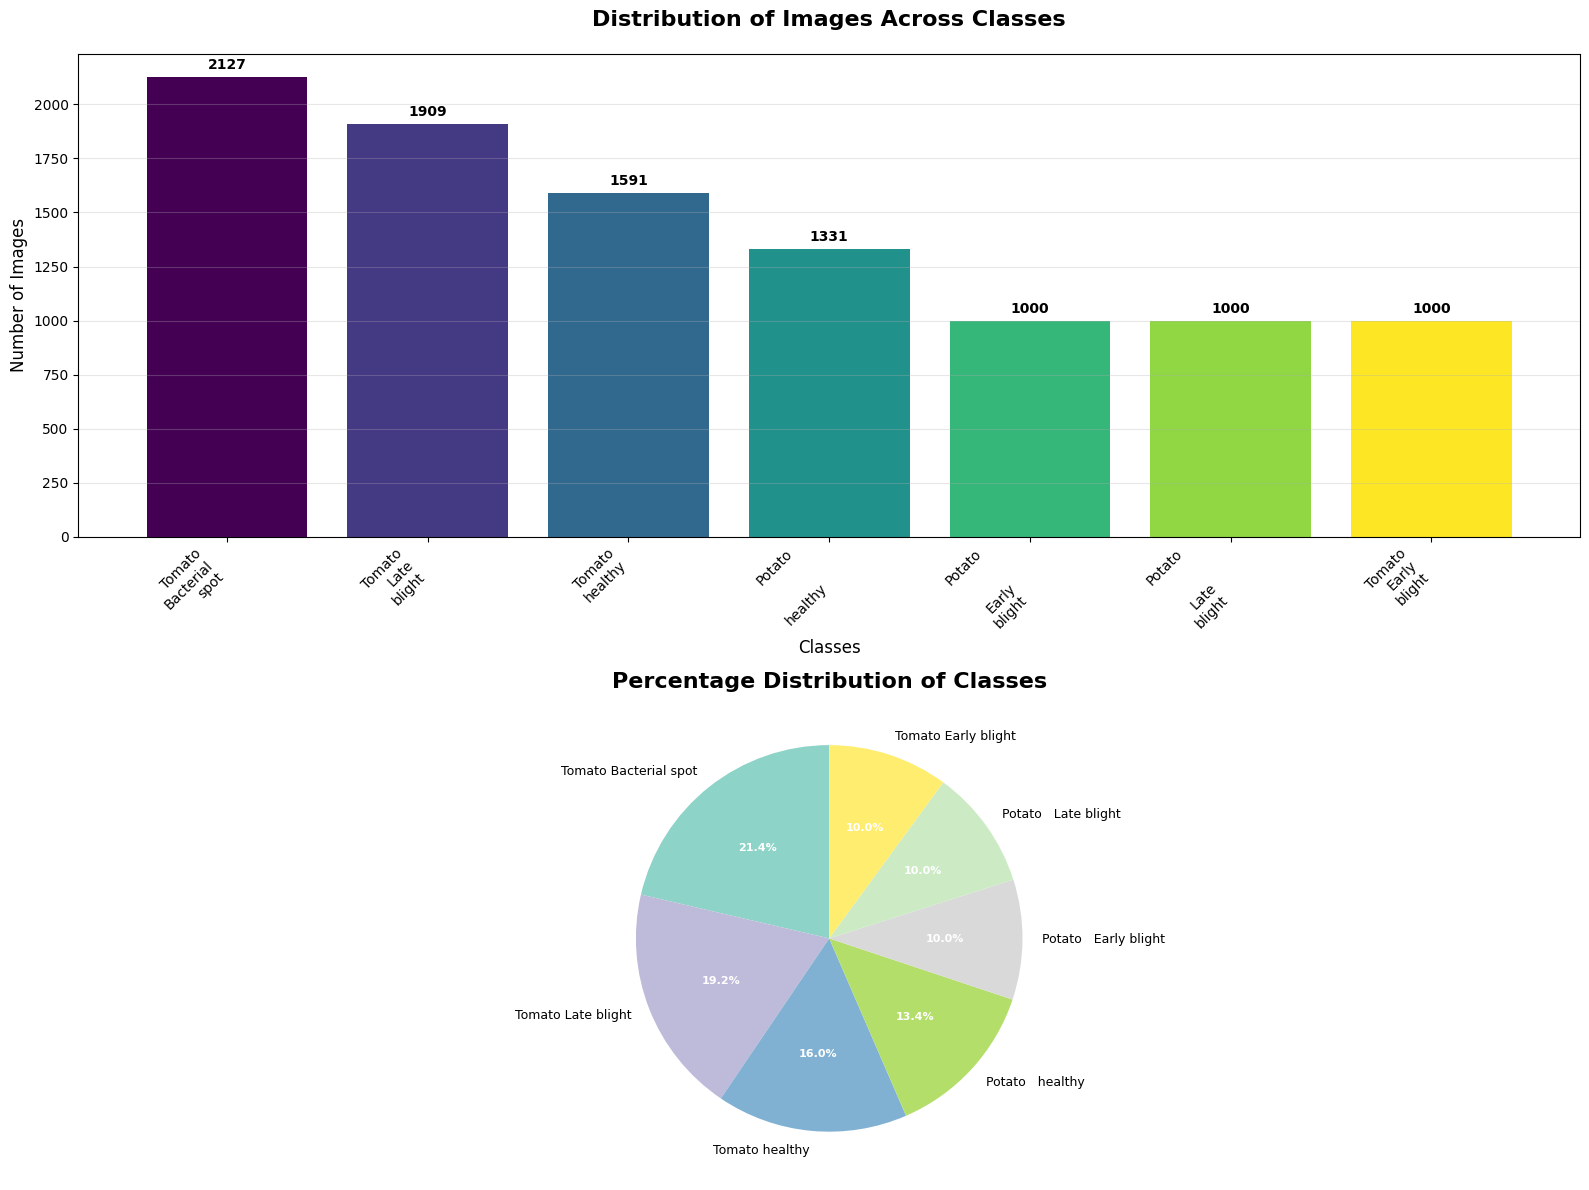

Class Distribution Statistics:
Most populated class: Tomato_Bacterial_spot (2127 images)
Least populated class: Potato___Early_blight (1000 images)
Imbalance ratio: 2.13:1


In [5]:
print("\n")
print("Visualize Class Distribution (partial code from GenAI)")
print("\n")

# Sort classes by count for better visualization
sorted_classes = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Bar plot
bars = ax1.bar(range(len(sorted_classes)), list(sorted_classes.values()), 
               color=plt.cm.viridis(np.linspace(0, 1, len(sorted_classes))))
ax1.set_title('Distribution of Images Across Classes', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Classes', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xticks(range(len(sorted_classes)))
ax1.set_xticklabels([name.replace('_', '\n') for name in sorted_classes.keys()], 
                    rotation=45, ha='right', fontsize=10)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(sorted_classes.values())*0.01,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

ax1.grid(axis='y', alpha=0.3)

# Pie chart
colors = plt.cm.Set3(np.linspace(0, 1, len(sorted_classes)))
wedges, texts, autotexts = ax2.pie(list(sorted_classes.values()), 
                                   labels=[name.replace('_', ' ') for name in sorted_classes.keys()], 
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Percentage Distribution of Classes', fontsize=16, fontweight='bold')

# Improve text readability
for text in texts:
    text.set_fontsize(9)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)

plt.tight_layout()
plt.show()

# Print distribution statistics
print("Class Distribution Statistics:")
print(f"Most populated class: {max(sorted_classes, key=sorted_classes.get)} ({max(sorted_classes.values())} images)")
print(f"Least populated class: {min(sorted_classes, key=sorted_classes.get)} ({min(sorted_classes.values())} images)")
print(f"Imbalance ratio: {max(sorted_classes.values()) / min(sorted_classes.values()):.2f}:1")




SAMPLE IMAGES FROM EACH CLASS




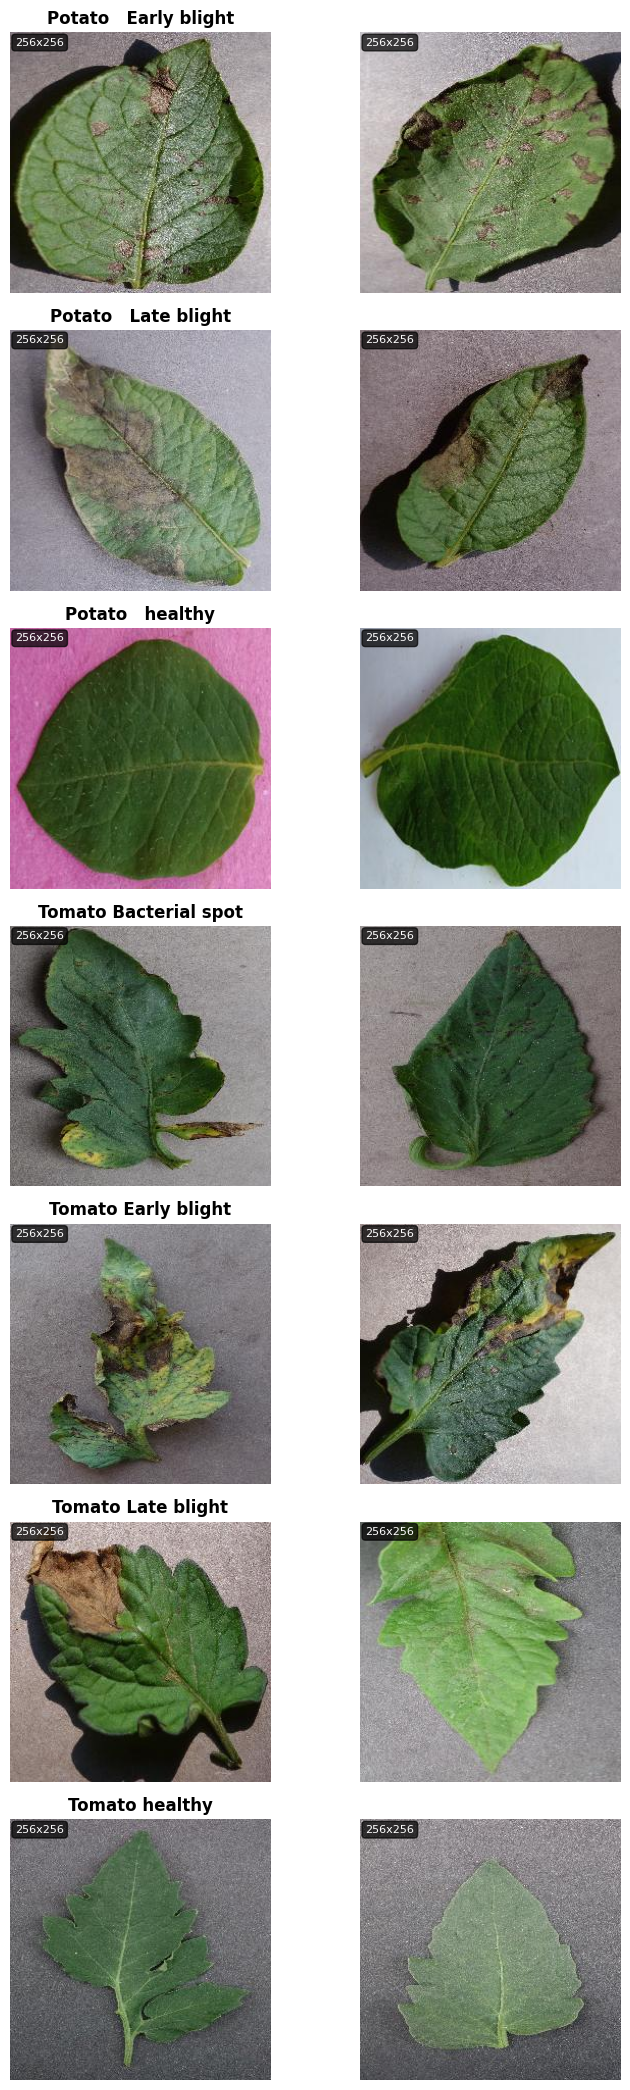

In [6]:
print("\n")
print("SAMPLE IMAGES FROM EACH CLASS")
print("\n")

n_samples = 2  # Number of samples per class
n_classes = len(class_names)

# Create a large figure to show samples
fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 4, n_classes * 3))

# Handle the case when there's only one class or one sample
if n_classes == 1:
    axes = [axes]
if n_samples == 1:
    axes = [[ax] for ax in axes]

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    # Get image files
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(valid_extensions)]
    
    # Sample random images
    sample_files = random.sample(image_files, min(n_samples, len(image_files)))
    
    for sample_idx, img_file in enumerate(sample_files):
        img_path = os.path.join(class_path, img_file)
        
        try:
            # Load and display image
            img = Image.open(img_path)
            
            ax = axes[class_idx][sample_idx]
            ax.imshow(img)
            ax.axis('off')
            
            if sample_idx == 0:  # Add class name to first image
                ax.set_title(f"{class_name.replace('_', ' ')}", fontsize=12, fontweight='bold')
            
            # Add image info
            ax.text(0.02, 0.98, f"{img.size[0]}x{img.size[1]}", 
                   transform=ax.transAxes, fontsize=8, 
                   verticalalignment='top', color='white',
                   bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
            
        except Exception as e:
            ax = axes[class_idx][sample_idx]
            ax.text(0.5, 0.5, f'Error loading\n{img_file}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
            print(f"Error loading {img_path}: {e}")

plt.tight_layout()
plt.show()


In [7]:
print("\n")
print("IMAGE PROPERTIES ANALYSIS")
print("\n")

# Sample images for analysis (to avoid processing all 20k images)
sample_size_per_class = 50
dimensions = []
channels_list = []
file_sizes = []
corrupted_images = []

print(f"Analyzing {sample_size_per_class} images per class...")

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(valid_extensions)]
    
    # Sample files for analysis
    sample_files = random.sample(image_files, min(sample_size_per_class, len(image_files)))
    
    for img_file in sample_files:
        img_path = os.path.join(class_path, img_file)
        
        try:
            # Check with PIL
            with Image.open(img_path) as img:
                img.verify()  # Verify integrity
            
            # Get properties
            with Image.open(img_path) as img:
                dimensions.append(img.size)  # (width, height)
                channels_list.append(len(img.getbands()) if hasattr(img, 'getbands') else 3)
                file_sizes.append(os.path.getsize(img_path))
            
            # Double-check with OpenCV
            img_cv = cv2.imread(img_path)
            if img_cv is None:
                raise ValueError("OpenCV cannot read image")
                
        except Exception as e:
            corrupted_images.append({
                'path': img_path,
                'class': class_name,
                'filename': img_file,
                'error': str(e)
            })

# Analyze results
widths = [d[0] for d in dimensions]
heights = [d[1] for d in dimensions]

print(f"\nAnalysis Results from {len(dimensions)} valid images:")
print(f" Image Dimensions:")
print(f"   Width  - Min: {min(widths):4d}, Max: {max(widths):4d}, Mean: {np.mean(widths):6.1f}")
print(f"   Height - Min: {min(heights):4d}, Max: {max(heights):4d}, Mean: {np.mean(heights):6.1f}")

print(f"\n Color Channels:")
channel_counts = Counter(channels_list)
for channels, count in channel_counts.items():
    print(f"   {channels} channels: {count} images ({count/len(channels_list)*100:.1f}%)")

print(f"\n File Sizes:")
file_sizes_kb = [size/1024 for size in file_sizes]
print(f"   Min: {min(file_sizes_kb):6.1f} KB")
print(f"   Max: {max(file_sizes_kb):6.1f} KB") 
print(f"   Mean: {np.mean(file_sizes_kb):6.1f} KB")

print(f"\n Corrupted Images Found: {len(corrupted_images)}")
if corrupted_images:
    print("   Corrupted files:")
    for corrupted in corrupted_images[:5]:  # Show first 5
        print(f"   - {corrupted['class']}/{corrupted['filename']}: {corrupted['error']}")
    if len(corrupted_images) > 5:
        print(f"   ... and {len(corrupted_images) - 5} more")



IMAGE PROPERTIES ANALYSIS


Analyzing 50 images per class...

Analysis Results from 350 valid images:
 Image Dimensions:
   Width  - Min:  256, Max:  256, Mean:  256.0
   Height - Min:  256, Max:  256, Mean:  256.0

 Color Channels:
   3 channels: 350 images (100.0%)

 File Sizes:
   Min:    5.3 KB
   Max:   27.0 KB
   Mean:   15.6 KB

 Corrupted Images Found: 0




VISUALIZING IMAGE PROPERTIES




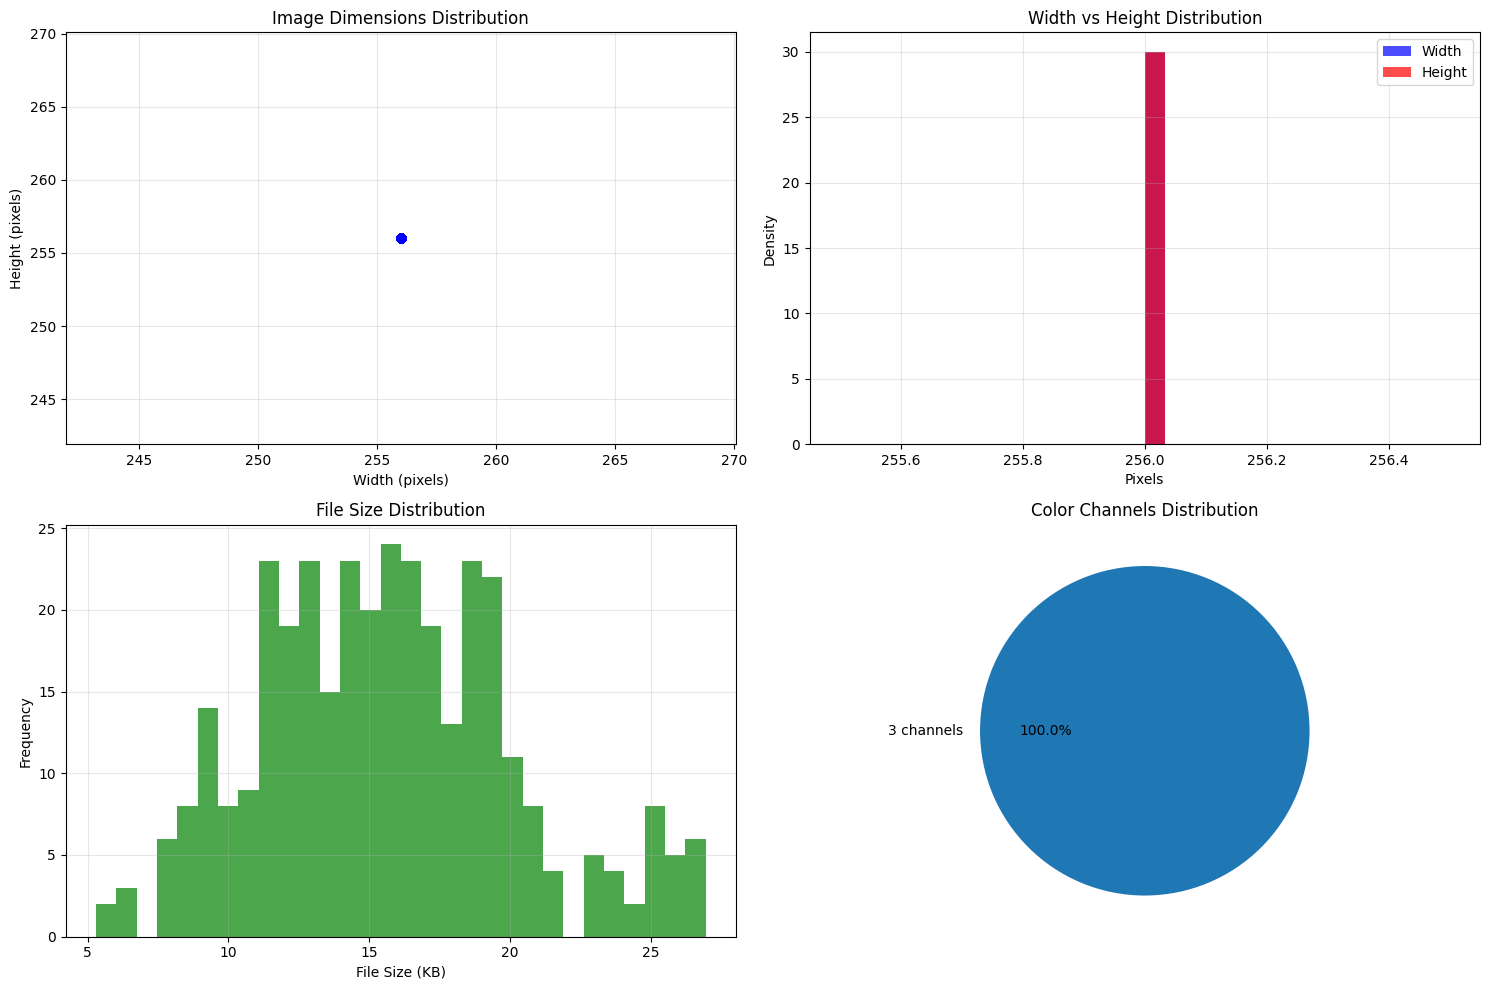

In [8]:
print("\n")
print("VISUALIZING IMAGE PROPERTIES")
print("\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Dimensions scatter plot
axes[0,0].scatter(widths, heights, alpha=0.6, color='blue')
axes[0,0].set_xlabel('Width (pixels)')
axes[0,0].set_ylabel('Height (pixels)')
axes[0,0].set_title('Image Dimensions Distribution')
axes[0,0].grid(True, alpha=0.3)

# Width vs Height histogram
axes[0,1].hist(widths, bins=30, alpha=0.7, label='Width', color='blue', density=True)
axes[0,1].hist(heights, bins=30, alpha=0.7, label='Height', color='red', density=True)
axes[0,1].set_xlabel('Pixels')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('Width vs Height Distribution')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# File size distribution
axes[1,0].hist(file_sizes_kb, bins=30, alpha=0.7, color='green')
axes[1,0].set_xlabel('File Size (KB)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('File Size Distribution')
axes[1,0].grid(True, alpha=0.3)

# Channel distribution pie chart
channel_labels = [f'{ch} channels' for ch in channel_counts.keys()]
axes[1,1].pie(channel_counts.values(), labels=channel_labels, autopct='%1.1f%%')
axes[1,1].set_title('Color Channels Distribution')

plt.tight_layout()
plt.show()


In [9]:
if corrupted_images:
    print("\n")
    print("CLEANING DATASET")
    print("\n")
    
    print(f"Found {len(corrupted_images)} corrupted images.")
    response = input("Do you want to remove corrupted images? (y/n): ").lower().strip()
    
    if response == 'y':
        removed_count = 0
        failed_removal = 0
        
        for corrupted in corrupted_images:
            try:
                os.remove(corrupted['path'])
                removed_count += 1
                print(f" Removed: {corrupted['class']}/{corrupted['filename']}")
            except Exception as e:
                failed_removal += 1
                print(f" Failed to remove: {corrupted['class']}/{corrupted['filename']} - {e}")
        
        print(f"\n Cleanup Summary:")
        print(f"   Successfully removed: {removed_count} files")
        print(f"   Failed to remove: {failed_removal} files")
        
        # Update counts after cleaning
        print("\n Recounting images after cleanup...")
        for class_name in class_names:
            class_path = os.path.join(dataset_path, class_name)
            image_files = [f for f in os.listdir(class_path) 
                           if f.lower().endswith(valid_extensions)]
            old_count = class_counts[class_name]
            class_counts[class_name] = len(image_files)
            if old_count != len(image_files):
                print(f"   {class_name}: {old_count} → {len(image_files)} images")
    else:
        print(" Skipping cleanup. Corrupted images remain in dataset.")
else:
    print("\n No corrupted images found. Dataset is clean!")


 No corrupted images found. Dataset is clean!


In [10]:
print("\n")
print("CREATING TRAIN/TEST SPLIT")
print("\n")

# Output directory for processed dataset
output_dir = "new-processed-plantvillage"
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create main directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print(f" Creating processed dataset in: {output_dir}")
print(f"   Train directory: {train_dir}")
print(f"   Test directory: {test_dir}")



CREATING TRAIN/TEST SPLIT


 Creating processed dataset in: new-processed-plantvillage
   Train directory: new-processed-plantvillage/train
   Test directory: new-processed-plantvillage/test


In [11]:
print("\n")
print("PERFROM TRAIN/TEST SPLIT")
print("\n")

#initialise 
split_info = {}
total_train = 0
total_test = 0

print(f"\n Splitting data with {int((1-TEST_SIZE)*100)}% train / {int(TEST_SIZE*100)}% test ratio...")

for class_name in class_names:
    print(f"\nProcessing: {class_name}")
    
    # Create class directories in train and test folders
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Get all valid images for this class
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(valid_extensions)]
    
    # Create full paths
    image_paths = [os.path.join(class_path, f) for f in image_files]
    
    # Split the data
    if len(image_paths) < 2:
        print(f"   Warning: Only {len(image_paths)} image(s). Putting all in training.")
        train_paths, test_paths = image_paths, []
    else:
        train_paths, test_paths = train_test_split(
            image_paths,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE,
            shuffle=True
        )
    
    # Copy files to respective directories
    print(f" Copying {len(train_paths)} images to train folder...")
    for img_path in train_paths:
        filename = os.path.basename(img_path)
        shutil.copy2(img_path, os.path.join(train_class_dir, filename))
    
    print(f" Copying {len(test_paths)} images to test folder...")
    for img_path in test_paths:
        filename = os.path.basename(img_path)
        shutil.copy2(img_path, os.path.join(test_class_dir, filename))
    
    # Store split information
    split_info[class_name] = {
        'total': len(image_paths),
        'train': len(train_paths),
        'test': len(test_paths)
    }
    
    total_train += len(train_paths)
    total_test += len(test_paths)
    
    print(f" Split complete: {len(train_paths)} train, {len(test_paths)} test")



PERFROM TRAIN/TEST SPLIT



 Splitting data with 70% train / 30% test ratio...

Processing: Potato___Early_blight
 Copying 700 images to train folder...
 Copying 300 images to test folder...
 Split complete: 700 train, 300 test

Processing: Potato___Late_blight
 Copying 700 images to train folder...
 Copying 300 images to test folder...
 Split complete: 700 train, 300 test

Processing: Potato___healthy
 Copying 931 images to train folder...
 Copying 400 images to test folder...
 Split complete: 931 train, 400 test

Processing: Tomato_Bacterial_spot
 Copying 1488 images to train folder...
 Copying 639 images to test folder...
 Split complete: 1488 train, 639 test

Processing: Tomato_Early_blight
 Copying 700 images to train folder...
 Copying 300 images to test folder...
 Split complete: 700 train, 300 test

Processing: Tomato_Late_blight
 Copying 1336 images to train folder...
 Copying 573 images to test folder...
 Split complete: 1336 train, 573 test

Processing: Tomato_healthy
 Cop

In [12]:
print("\n")
print("PREPROCESSING COMPLETE ")
print("\n")

total_processed = total_train + total_test

print(f" DATASET SUMMARY:")
print(f"   Total Classes: {len(class_names)}")
print(f"   Total Images Processed: {total_processed:,}")
print(f"   Training Images: {total_train:,} ({total_train/total_processed*100:.1f}%)")
print(f"   Testing Images: {total_test:,} ({total_test/total_processed*100:.1f}%)")

print(f"\n OUTPUT STRUCTURE:")
print(f"   {output_dir}/")
print(f"   ├── train/ ({total_train:,} images)")
print(f"   └── test/ ({total_test:,} images)")
print(f"       Each containing {len(class_names)} class folders")

print(f"\n SPLIT DETAILS BY CLASS:")
print(f"{'Class Name':<40} {'Total':>8} {'Train':>8} {'Test':>7} {'Train%':>8}")
print("-" * 75)

for class_name, info in split_info.items():
    train_pct = info['train'] / info['total'] * 100 if info['total'] > 0 else 0
    print(f"{class_name:<40} {info['total']:>8} {info['train']:>8} {info['test']:>7} {train_pct:>7.1f}%")

print(f"\n QUALITY METRICS:")
print(f"   Corrupted Images Found: {len(corrupted_images)}")
if len(corrupted_images) > 0:
    print(f"   Data Quality Score: {((total_processed)/(total_processed + len(corrupted_images)))*100:.2f}%")
else:
    print(f"   Data Quality Score: 100.0%")

# Check class balance
counts = [info['total'] for info in split_info.values()]
imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
print(f"   Class Imbalance Ratio: {imbalance_ratio:.2f}:1")

print(f"\n NEXT STEPS:")
print(f"   1. Use '{train_dir}' for model training")
print(f"   2. Use '{test_dir}' for model evaluation") 




PREPROCESSING COMPLETE 


 DATASET SUMMARY:
   Total Classes: 7
   Total Images Processed: 9,958
   Training Images: 6,968 (70.0%)
   Testing Images: 2,990 (30.0%)

 OUTPUT STRUCTURE:
   new-processed-plantvillage/
   ├── train/ (6,968 images)
   └── test/ (2,990 images)
       Each containing 7 class folders

 SPLIT DETAILS BY CLASS:
Class Name                                  Total    Train    Test   Train%
---------------------------------------------------------------------------
Potato___Early_blight                        1000      700     300    70.0%
Potato___Late_blight                         1000      700     300    70.0%
Potato___healthy                             1331      931     400    69.9%
Tomato_Bacterial_spot                        2127     1488     639    70.0%
Tomato_Early_blight                          1000      700     300    70.0%
Tomato_Late_blight                           1909     1336     573    70.0%
Tomato_healthy                               1591    